In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('BTC-USD.csv')


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.shape

(3134, 7)

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3134.000000,3134.000000,3134.000000,3134.000000,3134.000000,3.134000e+03
mean,13224.257665,13554.084113,12862.365763,13232.339085,13232.339085,1.660195e+10
std,16047.608177,16455.811396,15580.239674,16045.532868,16045.532868,1.976022e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,718.275009,737.604751,708.717239,724.903015,724.903015,1.145578e+08
50%,7387.667236,7535.353515,7233.038086,7388.873535,7388.873535,9.157066e+09
75%,19133.139649,19390.275879,18697.012207,19141.313476,19141.313476,2.803098e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

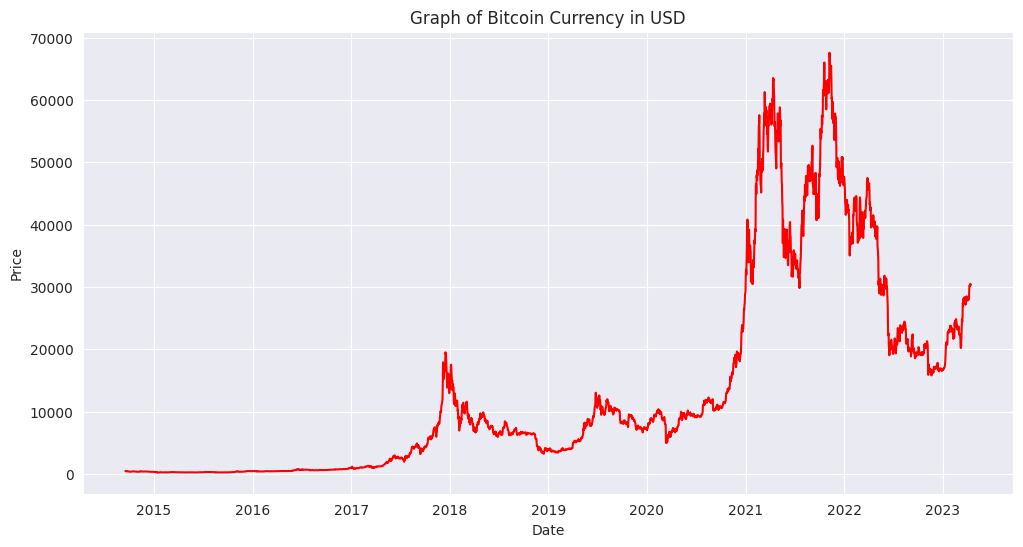

In [8]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Close', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Graph of Bitcoin Currency in USD')
plt.show()

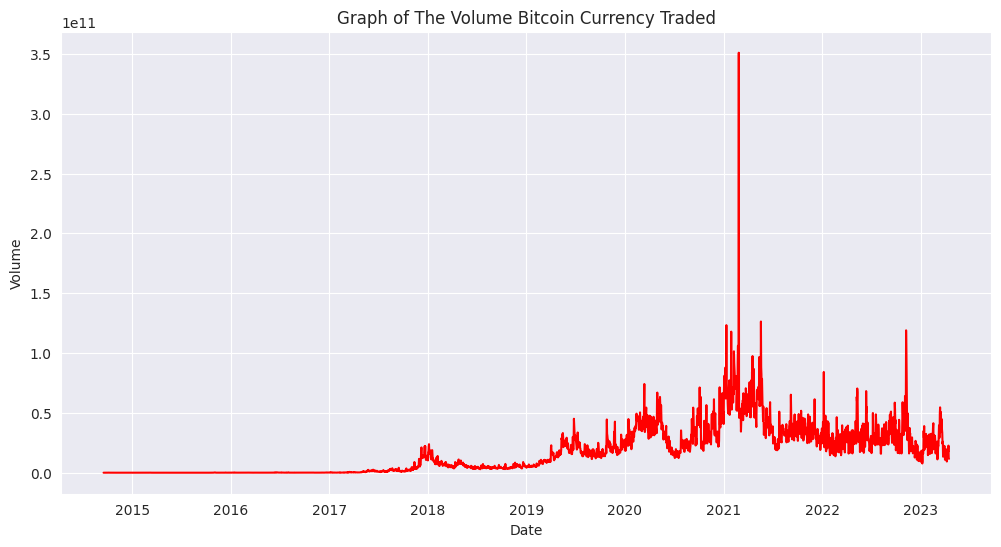

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Volume', color='red')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Graph of The Volume Bitcoin Currency Traded')
plt.show()

In [10]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [11]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)


In [12]:
df = df.set_index('Date')


In [13]:
df.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [14]:
# Define the state space and action space
state_space = 1
action_space = 3  # Buy, sell, hold


In [15]:
# Define the DQN model
def build_model(state_space, action_space):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(state_space,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(action_space, activation=None)
    ])
    return model

In [16]:
class DQNAgent:
    def __init__(self, state_space, action_space):
        # Initialize the state and action spaces
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01 # Minimum exploration rate
        self.learning_rate = 0.0008
        self.gamma = 0.95  # Discount factor for future rewards
        self.memory = [] # Memory buffer to store experiences
        self.batch_size = 16
        self.model = build_model(state_space, action_space) # Build the deep Q-network model

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in memory buffer
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action based on epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # Use the Q-network to predict Q-values for each action
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self):
         # Sample a mini-batch of experiences from memory buffer
        if len(self.memory) < self.batch_size:
            return
        indices = np.random.choice(len(self.memory), size=self.batch_size, replace=False)
        batch = [(self.memory[i][0], self.memory[i][1], self.memory[i][2], self.memory[i][3], self.memory[i][4]) for i in indices]
        # Update the Q-values for the selected experiences
        for state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                # Use the Q-network to predict Q-values for the next state
                q_update = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            # Use the Q-network to predict Q-values for the current state
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            # Train the Q-network on the updated Q-values
            self.model.fit(state, q_values, verbose=0)
             # Decay the exploration rate
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


In [17]:
# Create the DQN agent
Bitcoin_agent = DQNAgent(state_space, action_space)

In [19]:
# Train the DQN agent
max_iterations = 10
iteration = 0
for i in range(5):
    state = df.iloc[0]
    print("Shape of state:", state.shape)
    total_profit = 0
    for t in range(len(df)-1):
        action = Bitcoin_agent.act(state)
        next_state = df.iloc[t+1]
        reward = 0
        if action == 0:  # Buy
            profit = df.iloc[t+1]['Close'] - df.iloc[t]['Close']
            if profit > 0:
                reward = 1
            else:
                reward = -1
            total_profit += profit
        elif action == 1:  # Sell
            profit = df.iloc[t]['Close'] - df.iloc[t+1]['Close']
            if profit > 0:
                reward = 1
            else:
                reward = -1
            total_profit += profit
        else:  # Hold
            profit = 0
        Bitcoin_agent.remember(state, action, reward, next_state, False)
        state = next_state

        # Define the experience tuple
        e = (state, action, reward, next_state, False)

        # Train the agent on the updated experiences
        Bitcoin_agent.model.compile(optimizer='adam', loss='mse')
        Bitcoin_agent.model.fit(x=np.array([e[0] for e in Bitcoin_agent.memory]),
                                y=np.array([np.array([r + Bitcoin_agent.gamma * np.max(Bitcoin_agent.model.predict(e[3])[0])
                                            if not e[4] else r]) for r in np.array([e[2] for e in Bitcoin_agent.memory])]),
                                epochs=10, verbose=2)
        # Decay the exploration rate
        Bitcoin_agent.epsilon = max(Bitcoin_agent.epsilon * Bitcoin_agent.epsilon_decay, Bitcoin_agent.epsilon_min)

        # Increment the iteration counter
        iteration += 1

        # Check if max_iterations has been reached
        if iteration >= max_iterations:
            break

    print('Episode: {}, Total Profit: {}'.format(i, total_profit))
print("Training has finished now you can save the model.")

Shape of state: (1,)
1/1 [==============================] - 0s 21ms/step
Epoch 1/10
3/3 - 1s - loss: 6.2960 - 795ms/epoch - 265ms/step
Epoch 2/10
3/3 - 0s - loss: 6.2228 - 14ms/epoch - 5ms/step
Epoch 3/10
3/3 - 0s - loss: 2.4407 - 16ms/epoch - 5ms/step
Epoch 4/10
3/3 - 0s - loss: 3.8593 - 12ms/epoch - 4ms/step
Epoch 5/10
3/3 - 0s - loss: 1.9608 - 13ms/epoch - 4ms/step
Epoch 6/10
3/3 - 0s - loss: 2.3798 - 12ms/epoch - 4ms/step
Epoch 7/10
3/3 - 0s - loss: 1.6993 - 9ms/epoch - 3ms/step
Epoch 8/10
3/3 - 0s - loss: 1.6672 - 9ms/epoch - 3ms/step
Epoch 9/10
3/3 - 0s - loss: 1.5411 - 9ms/epoch - 3ms/step
Epoch 10/10
3/3 - 0s - loss: 1.2900 - 7ms/epoch - 2ms/step
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
3/3 - 1s - loss: 9.4156 - 571ms/epoch - 190ms/step
Epoch 2/10
3/3 - 0s - loss: 8.4147 - 12ms/epoch - 4ms/step
Epoch 3/10
3/3 - 0s - loss: 2.4962 - 9ms/epoch - 3ms/step
Epoch 4/10
3/3 - 0s - loss: 5.4251 - 8ms/epoch - 3ms/step
Epoch 5/10
3/3 - 0s - loss: 1.9637 - 11ms/epoch 

In [20]:
Bitcoin_agent.model.save('Bitcoin_DQN_model.h5')


In [22]:
df.shape

(3134, 1)

In [27]:
from keras.models import load_model

# Load the saved model
Bitcoin_DQN_model = load_model('Bitcoin_DQN_model.h5')

# Use the model to predict the next 30 days' bitcoin prices to guide trading decisions.
next_30_days = pd.concat([df.iloc[[-1]]] * 30).reset_index(drop=True)
next_30_days *= (1 + np.random.normal(0, 0.1, (30, df.shape[1])))

for t in range(30):
    state = next_30_days.iloc[t]
    action = Bitcoin_agent.act(state)
    if action == 0:
        print("Day {}: Predicted action: Buy".format(t+1))
    elif action == 1:
        print("Day {}: Predicted action: Sell".format(t+1))
    else:
        print("Day {}: Predicted action: Hold".format(t+1))



Day 1: Predicted action: Sell
Day 2: Predicted action: Hold
1/1 [==============================] - 0s 24ms/step
Day 3: Predicted action: Hold
Day 4: Predicted action: Sell
1/1 [==============================] - 0s 17ms/step
Day 5: Predicted action: Hold
Day 6: Predicted action: Buy
1/1 [==============================] - 0s 16ms/step
Day 7: Predicted action: Hold
1/1 [==============================] - 0s 20ms/step
Day 8: Predicted action: Hold
1/1 [==============================] - 0s 19ms/step
Day 9: Predicted action: Hold
Day 10: Predicted action: Buy
Day 11: Predicted action: Hold
1/1 [==============================] - 0s 18ms/step
Day 12: Predicted action: Hold
1/1 [==============================] - 0s 18ms/step
Day 13: Predicted action: Hold
1/1 [==============================] - 0s 19ms/step
Day 14: Predicted action: Hold
Day 15: Predicted action: Hold
1/1 [==============================] - 0s 18ms/step
Day 16: Predicted action: Hold
Day 17: Predicted action: Sell
1/1 [===========

In [28]:
# Load the saved model
Bitcoin_DQN_model = load_model('Bitcoin_DQN_model.h5')

# Convert to weekly frequency
weekly_df = df.resample('W').last()

# Use the model to predict the next 20 weeks' bitcoin prices to guide trading decisions.
next_20_weeks = pd.concat([weekly_df.iloc[[-1]]] * 20).reset_index(drop=True)
next_20_weeks *= (1 + np.random.normal(0, 0.1, (20, weekly_df.shape[1])))

for t in range(20):
    state = next_20_weeks.iloc[t]
    action = Bitcoin_agent.act(state)
    if action == 0:
        print("Week {}: Predicted action: Buy".format(t+1))
    elif action == 1:
        print("Week {}: Predicted action: Sell".format(t+1))
    else:
        print("Week {}: Predicted action: Hold".format(t+1))


Week 1: Predicted action: Buy
Week 2: Predicted action: Hold
Week 3: Predicted action: Buy
1/1 [==============================] - 0s 43ms/step
Week 4: Predicted action: Hold
Week 5: Predicted action: Sell
1/1 [==============================] - 0s 69ms/step
Week 6: Predicted action: Hold
Week 7: Predicted action: Hold
1/1 [==============================] - 0s 107ms/step
Week 8: Predicted action: Hold
1/1 [==============================] - 0s 42ms/step
Week 9: Predicted action: Hold
1/1 [==============================] - 0s 18ms/step
Week 10: Predicted action: Hold
1/1 [==============================] - 0s 17ms/step
Week 11: Predicted action: Hold
Week 12: Predicted action: Sell
Week 13: Predicted action: Hold
1/1 [==============================] - 0s 17ms/step
Week 14: Predicted action: Hold
Week 15: Predicted action: Sell
1/1 [==============================] - 0s 20ms/step
Week 16: Predicted action: Hold
Week 17: Predicted action: Hold
Week 18: Predicted action: Buy
1/1 [==============

In [29]:
# Load the saved model
Bitcoin_DQN_model = load_model('Bitcoin_DQN_model.h5')

# Convert to weekly frequency
monthly_df = df.resample('M').last()

# Use the model to predict the next 6 months' bitcoin prices to guide trading decisions.
next_6_months = pd.concat([monthly_df.iloc[[-1]]] * 6).reset_index(drop=True)
next_6_months *= (1 + np.random.normal(0, 0.1, (6, monthly_df.shape[1])))

for t in range(6):
    state = next_6_months.iloc[t]
    action = Bitcoin_agent.act(state)
    if action == 0:
        print("Month {}: Predicted action: Buy".format(t+1))
    elif action == 1:
        print("Month {}: Predicted action: Sell".format(t+1))
    else:
        print("Month {}: Predicted action: Hold".format(t+1))


1/1 [==============================] - 0s 25ms/step
Month 1: Predicted action: Hold
1/1 [==============================] - 0s 19ms/step
Month 2: Predicted action: Hold
1/1 [==============================] - 0s 18ms/step
Month 3: Predicted action: Hold
1/1 [==============================] - 0s 17ms/step
Month 4: Predicted action: Hold
Month 5: Predicted action: Hold
Month 6: Predicted action: Buy
